In [104]:
pip install wordcloud

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


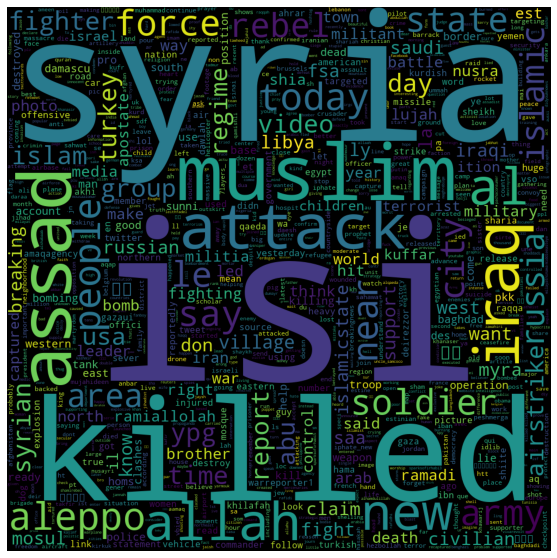

In [105]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

df = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv")

junk = re.compile("al|RT|\n|&.*?;|http[s](?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)*")
tweets = [junk.sub(" ", t) for t in df.tweets]

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(tweets)

terms = vec.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

#### TOPIC MODEL TO GAIN SOME GRANULARITY

In [106]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10).fit(tfv)
for idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % idx)
    print(" ".join([terms[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("")

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic #0:
syria assad aleppo russia ypg turkey rebels breakingnews ramiallolah myra

Topic #1:
state islamic islamic state state fighters fighters state forces fighting forces fighting islamic breaking islamic

Topic #2:
nid gazaui nid gazaui gazaui breaking aleppo breaking rebels captured saa huge

Topic #3:
isis iraq ramiallolah iraq army usa attack mosul army aamaq claims

Topic #4:
islamicstate amaqagency breaking fighters breaking islamicstate forces amaqagency islamicstate city islamicstate fighters martyrdom

Topic #5:
scotsmaninfidel sassysassyred ele7vn spicylatte123 1_texanna kafirkaty sassysassyred scotsmaninfidel kafirkaty ele7vn scotsmaninfidel 1_texanna jailamx

Topic #6:
killed soldiers today soldiers killed airstrikes iraqi civilians killed today iraqi soldiers russian

Topic #7:
al nusra qaeda al qaeda ahrar islam sham abu al nusra jabhat

Topic #8:
army sinai egyptian ied egyptian army explosion ied explosion targeted sheikh zuwaid

Topic #9:
allah akhi jazak accept a

#### Top 10 Users and their Topic Distributions
- Evidently Uncle_SamCoCo likes to talk about Al Qaida so does Ishfaq_Ahmad 
- mobi_ayubi likes to talk about the islamic state 
- Uncle_SamCoCo also talks a lot about Al-Nusra Front or Jabhat al-Nusra which is the Front for the Conquest of Syria/the Levant after July 2016, and also described as al-Qaeda. It was a Salafi-Jihadist militant organization fighting against Syrian government forces in the Syrian Civil War. Its aim was to overthrow Bashar al-Assad's Ba'athist government and establish an Islamic state in Syria. al-Nusra was the most aggressive and successful of the rebel forces.
- Topic 8 is about the non- state armed group Wilayat Sinai. On 31 July 2015, the Egyptian military bombed areas of the North Sinai towns of al-Arish and Sheikh Zuweid, killing 20 suspected militants. mobi_ayubi talks about this

<AxesSubplot:xlabel='username'>

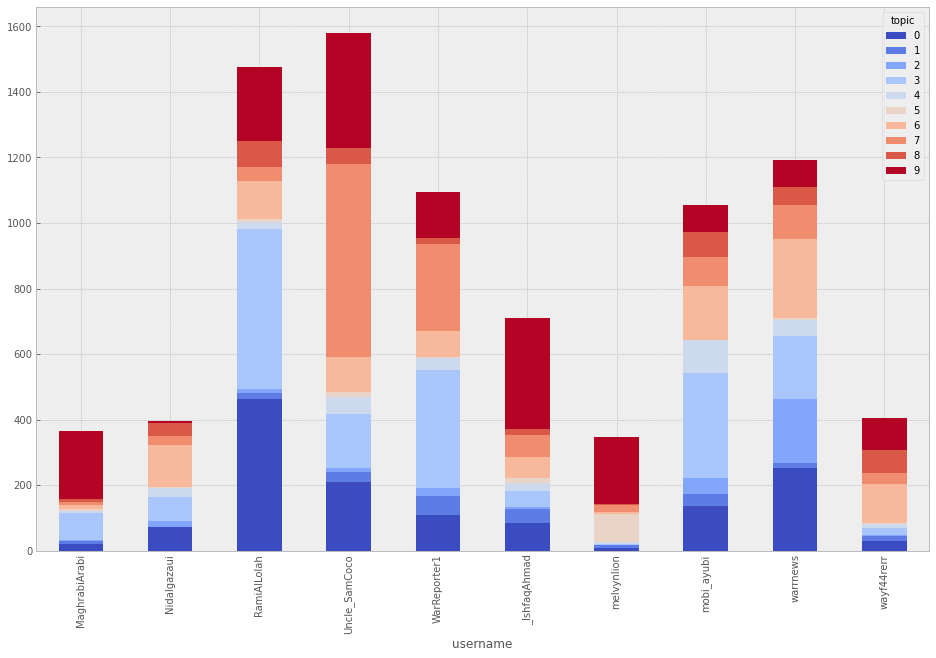

In [107]:
from matplotlib import style

style.use('bmh')

df['topic'] = np.argmax(nmf.transform(vec.transform(tweets)), axis=1)
top10_users = df[df.username.isin(df.username.value_counts()[:10].keys().tolist())]
pd.crosstab(top10_users.username, top10_users.topic).plot.bar(stacked=True, figsize=(16, 10), colormap="coolwarm")

#### USERS CLUSTERED BY POST HOUR

In [108]:
import seaborn as sns

%matplotlib inline


df = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv", parse_dates=['time'],
                 infer_datetime_format=True, encoding="utf8")

hour_profiles = df.groupby('username').apply(lambda x: x.time.dt.hour.value_counts()) \
    .unstack().fillna(0)
hour_profiles.index = [w[0:40] for w in hour_profiles.index]
hour_profiles.columns = ["%04d" % (x * 100) for x in range(24)]
hour_profiles.iloc[:5,:5]

,0000,0100,0200,0300,0400
04_8_1437,6.0,0.0,0.0,0.0,3.0
06230550_IS,0.0,0.0,0.0,5.0,0.0
1515Ummah,0.0,0.0,0.0,0.0,0.0
1Dawlah_III,10.0,7.0,2.0,9.0,14.0
432Mryam,3.0,4.0,0.0,0.0,3.0


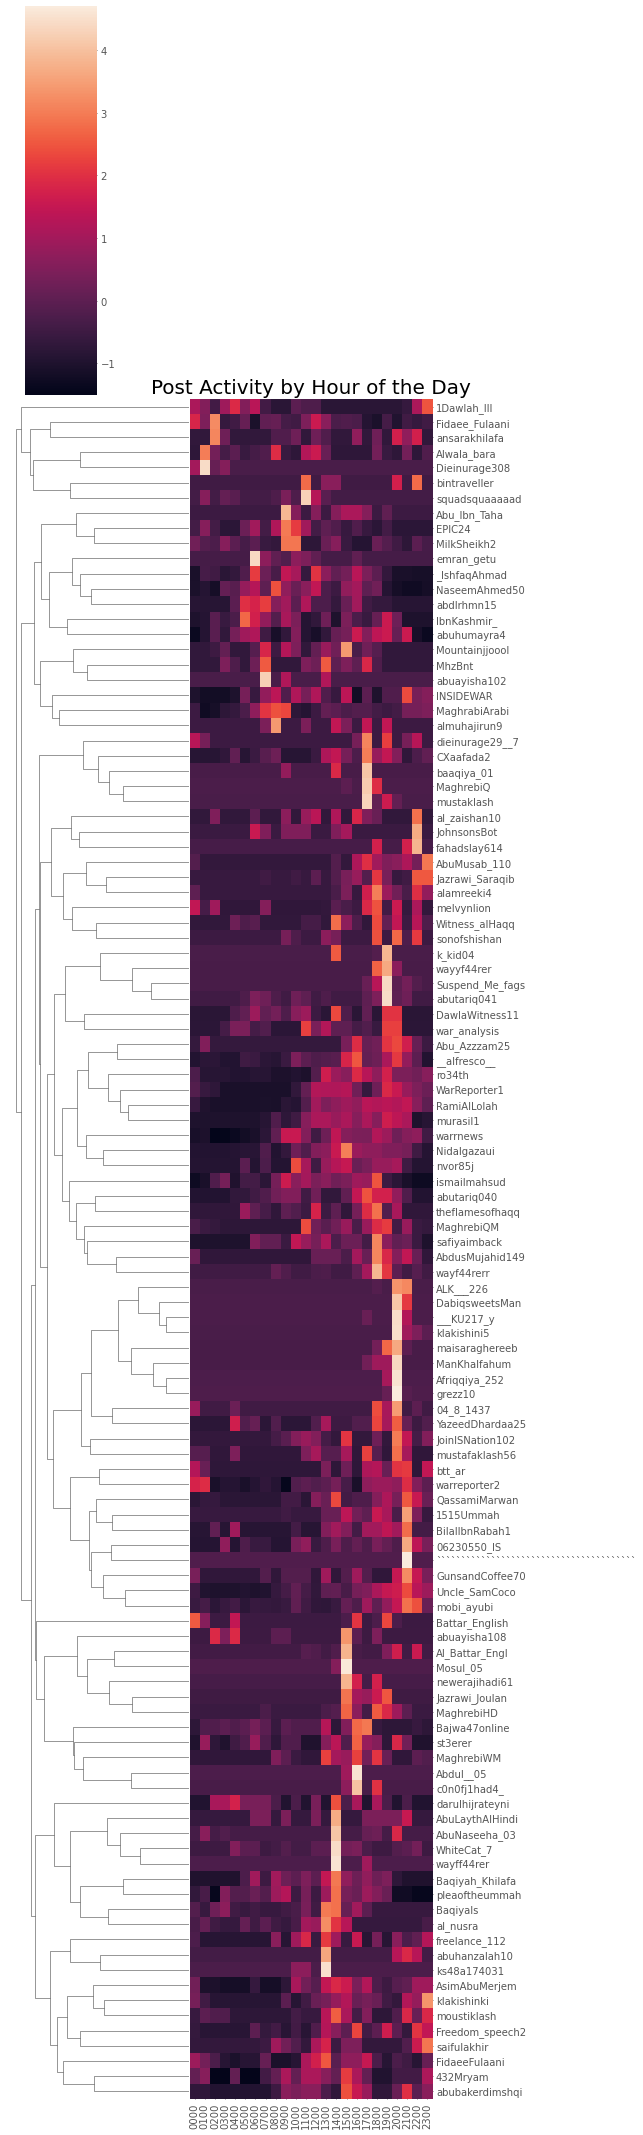

In [109]:
g = sns.clustermap(hour_profiles, z_score=0,
                   col_cluster=False, row_cluster=True,
                   figsize=(20, 30))
wmult=.25
hmult=.75
hm_pos = g.ax_heatmap.get_position()
rd_pos = g.ax_row_dendrogram.get_position()
cd_pos = g.ax_col_dendrogram.get_position()
g.ax_heatmap.set_position([hm_pos.x0 - rd_pos.width * (1-hmult),
                           hm_pos.y0,
                           hm_pos.width * wmult,
                           hm_pos.height])
g.ax_row_dendrogram.set_position([rd_pos.x0,
                                  rd_pos.y0,
                                  rd_pos.width * hmult,
                                  rd_pos.height])
g.ax_col_dendrogram.set_position([cd_pos.x0 - rd_pos.width * (1-hmult),
                                  cd_pos.y0,
                                  cd_pos.width*wmult,
                                  cd_pos.height/2])
#g.cax.set_visible(False)
g.ax_heatmap.set_title("Post Activity by Hour of the Day", fontsize=20)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)
plt.show()

#### USERS CLUSTERED BY WEEKDAY/MINUTE PROFILE

In [110]:
from sklearn.preprocessing import StandardScaler

df['weekday'] = df.time.dt.dayofweek
df['hour'] = df.time.dt.hour
top50_users = df[df.username.isin(df.username.value_counts()[:50].keys().tolist())]
profile = top50_users.groupby('username').apply(lambda x: pd.crosstab(x.hour, x.weekday)).unstack().fillna(0)
profile = profile.applymap(lambda x: 1 if x > 0 else 0)
profile = pd.DataFrame(StandardScaler().fit_transform(profile), index=profile.index)
profile.iloc[10:14,10:14]

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


,10,11,12,13
username,,,,
CXaafada2,-0.592749,-0.561951,-0.623610,-0.717741
FidaeeFulaani,-0.592749,-0.561951,1.603567,-0.717741
Fidaee_Fulaani,1.687055,-0.561951,1.603567,1.393261
IbnKashmir_,-0.592749,-0.561951,-0.623610,-0.717741


In [111]:
from scipy.spatial.distance import cosine

sims = np.dot(profile, profile.T)
square_mag = np.diag(sims)
inv_square_mag = 1 / square_mag
inv_square_mag[np.isinf(inv_square_mag)] = 0
inv_mag = np.sqrt(inv_square_mag)
cosine = sims * inv_mag
cossims = pd.DataFrame(sims * inv_mag, index=profile.index, columns=profile.index)
cossims.values[[np.arange(len(cossims))]*2] = 0

print(cossims['RamiAlLolah'].sort_values(ascending=False)[1:11])
print(cossims['RamiAlLolah'].sort_values(ascending=False)[-10:])

username
warrnews         10.516803
ro34th            7.004774
MaghrabiArabi     6.800758
AsimAbuMerjem     5.792573
Uncle_SamCoco     5.415480
mobi_ayubi        5.263684
warreporter2      3.932123
murasil1          3.419142
safiyaimback      3.119021
Nidalgazaui       3.020421
Name: RamiAlLolah, dtype: float64
username
IbnKashmir_       -4.028375
Alwala_bara       -4.034896
al_zaishan10      -4.402553
1Dawlah_III       -4.466880
AbuMusab_110      -4.561291
Al_Battar_Engl    -4.620941
WhiteCat_7        -4.692331
MaghrebiWM        -4.703870
Jazrawi_Saraqib   -4.731984
Battar_English    -4.999219
Name: RamiAlLolah, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_6084\1894408505.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cossims.values[[np.arange(len(cossims))]*2] = 0


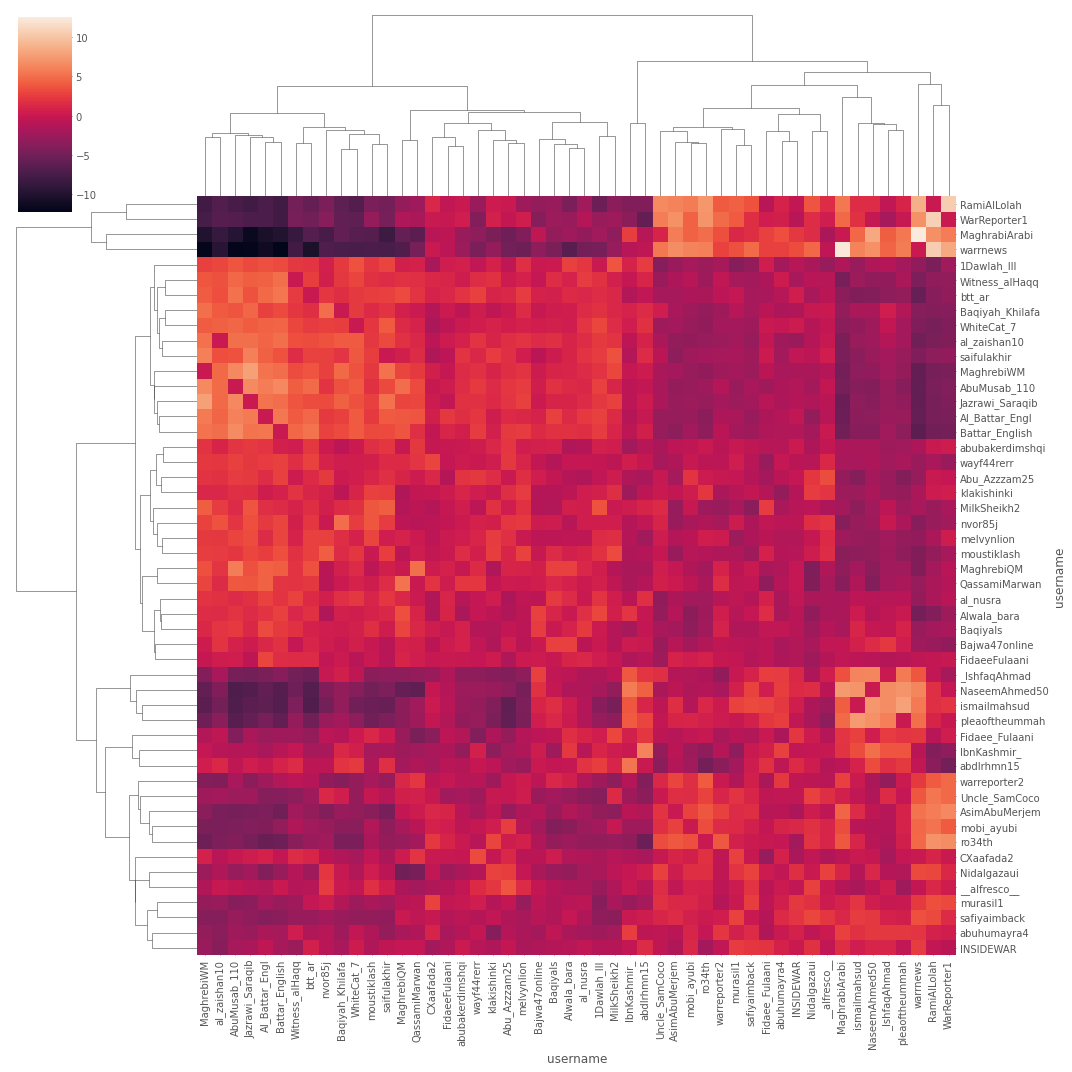

In [112]:
g = sns.clustermap(cossims, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)
plt.show()

#### Checking for top20 1-5grams as well as top20 mentions of usernames (@), tags (#) and urls.

In [113]:
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
data = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17410 entries, 0 to 17409
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            17410 non-null  object
 1   username        17410 non-null  object
 2   description     14728 non-null  object
 3   location        11432 non-null  object
 4   followers       17410 non-null  int64 
 5   numberstatuses  17410 non-null  int64 
 6   time            17410 non-null  object
 7   tweets          17410 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


#### Creating function to extract different items from tweets

In [114]:
regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

##### N-Grams
Stopwords will only be removed for 1-gram but not for 2-5 grams to get the n-grams as they were written

#### 1-gram

In [115]:
vect1 = CountVectorizer(analyzer="word", stop_words="english", min_df=200, decode_error="ignore", ngram_range=(1, 1), dtype=np.int32)

# applying Vectorizer to preprocessed tweets
sub11 = vect1.fit_transform(data["tweets"].map(lambda x: " ".join(preprocess(x, lowercase = True))).tolist())

# creating (word, count) list
sub12 = zip(vect1.get_feature_names(), np.asarray(sub11.sum(axis = 0)).ravel())

# getting Top20 words
sorted(sub12, key = lambda x: x[1], reverse = True)[0:20]

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('https', 9716),
 ('rt', 5884),
 ('isis', 2453),
 ('syria', 1705),
 ('al', 1684),
 ('amp', 1422),
 ('killed', 1308),
 ('army', 939),
 ('assad', 825),
 ('iraq', 825),
 ('state', 716),
 ('islamic', 690),
 ('aleppo', 678),
 ('allah', 650),
 ('ramiallolah', 578),
 ('near', 577),
 ('today', 572),
 ('breaking', 565),
 ('soldiers', 534),
 ('attack', 522)]

#### 2-gram

In [116]:
vect2 = CountVectorizer(analyzer="word", min_df=2, decode_error="ignore", ngram_range=(2, 2), dtype=np.int32)

# applying Vectorizer to preprocessed tweets
sub21 = vect2.fit_transform(data["tweets"].map(lambda x: " ".join(preprocess(x, lowercase = True))).tolist())

# creating (word, count) list
sub22 = zip(vect2.get_feature_names(), np.asarray(sub21.sum(axis = 0)).ravel())

# getting Top20 words
sorted(sub22, key = lambda x: x[1], reverse = True)[0:20]

[('https co', 8563),
 ('of the', 809),
 ('in the', 734),
 ('islamic state', 587),
 ('rt ramiallolah', 505),
 ('syria https', 474),
 ('in syria', 320),
 ('on the', 320),
 ('killed in', 304),
 ('rt nidalgazaui', 302),
 ('to the', 260),
 ('this is', 248),
 ('for the', 243),
 ('from the', 206),
 ('the islamic', 204),
 ('isis https', 193),
 ('is the', 188),
 ('by isis', 183),
 ('iraq https', 181),
 ('by the', 177)]

##### 3-gram

In [117]:
vect3 = CountVectorizer(analyzer="word", min_df=2, decode_error="ignore", ngram_range=(3, 3), dtype=np.int32)

# applying Vectorizer to preprocessed tweets
sub31 = vect3.fit_transform(data["tweets"].map(lambda x: " ".join(preprocess(x, lowercase = True))).tolist())

# creating (word, count) list
sub32 = zip(vect3.get_feature_names(), np.asarray(sub31.sum(axis = 0)).ravel())

# getting Top20 words
sorted(sub32, key = lambda x: x[1], reverse = True)[0:20]

[('syria https co', 374),
 ('the islamic state', 186),
 ('iraq https co', 153),
 ('isis https co', 153),
 ('aleppo https co', 107),
 ('the city of', 101),
 ('in the city', 91),
 ('city https co', 90),
 ('one of the', 72),
 ('in north aleppo', 69),
 ('ypg terror group', 65),
 ('in syria https', 63),
 ('rt ramiallolah isis', 61),
 ('in northern aleppo', 60),
 ('mosul https co', 58),
 ('is https co', 57),
 ('islamic state fighters', 53),
 ('them https co', 53),
 ('rt ramiallolah breakingnews', 52),
 ('fallujah https co', 51)]

#### 4-gram

In [118]:
vect4 = CountVectorizer(analyzer="word", min_df=2, decode_error="ignore", ngram_range=(4, 4), dtype=np.int32)

# applying Vectorizer to preprocessed tweets
sub41 = vect4.fit_transform(data["tweets"].map(lambda x: " ".join(preprocess(x, lowercase = True))).tolist())

# creating (word, count) list
sub42 = zip(vect4.get_feature_names(), np.asarray(sub41.sum(axis = 0)).ravel())

# getting Top20 words
sorted(sub42, key = lambda x: x[1], reverse = True)[0:20]

[('in the city of', 70),
 ('in syria https co', 55),
 ('islamic state https co', 38),
 ('for the sake of', 28),
 ('in iraq https co', 28),
 ('may allah accept him', 26),
 ('didyouknowvs did you know', 25),
 ('rt didyouknowvs did you', 25),
 ('of fallujah https co', 21),
 ('aleppo syria https co', 19),
 ('of the islamic state', 19),
 ('syria isis https co', 19),
 ('in aleppo https co', 18),
 ('isis claims responsibility of', 18),
 ('south of sheikh zuwaid', 18),
 ('the sake of allah', 18),
 ('cybernews website https co', 17),
 ('in libya https co', 17),
 ('in syria and iraq', 17),
 ('the islamic state https', 17)]

#### 5-gram

In [119]:
vect5 = CountVectorizer(analyzer="word", min_df=2, decode_error="ignore", ngram_range=(5, 5), dtype=np.int32)

# applying Vectorizer to preprocessed tweets
sub51 = vect5.fit_transform(data["tweets"].map(lambda x: " ".join(preprocess(x, lowercase = True))).tolist())

# creating (word, count) list
sub52 = zip(vect5.get_feature_names(), np.asarray(sub51.sum(axis = 0)).ravel())

# getting Top20 words
sorted(sub52, key = lambda x: x[1], reverse = True)[0:20]

[('rt didyouknowvs did you know', 25),
 ('for the sake of allah', 18),
 ('the islamic state https co', 16),
 ('https co 5klvsqhad8 https co', 13),
 ('glimpse at the work of', 12),
 ('sinai ied explosion targeted egyptian', 11),
 ('and more last week see', 10),
 ('audience growing via https co', 10),
 ('best rts this week came', 10),
 ('how your audience growing via', 10),
 ('ied explosion targeted egyptian army', 10),
 ('in the city of mosul', 10),
 ('in the city of sirte', 10),
 ('last week see https co', 10),
 ('more last week see https', 10),
 ('my best rts this week', 10),
 ('rts this week came from', 10),
 ('thanksall who were yours https', 10),
 ('who were yours https co', 10),
 ('your audience growing via https', 10)]

#### Usernames in tweets

In [120]:
tags = data["tweets"].map(lambda x: [tag for tag in preprocess(x, lowercase=True) if tag.startswith('@')])
tags = sum(tags, [])
tags[0:5]

['@khalidmaghrebi',
 '@seifulmaslul123',
 '@cheerleadunited',
 '@khalidmaghrebi',
 '@seifulmaslul123']

In [121]:
# Top20
Counter(tags).most_common(20)

[('@ramiallolah', 578),
 ('@nidalgazaui', 341),
 ('@warreporter1', 256),
 ('@7layers_', 116),
 ('@scotsmaninfidel', 79),
 ('@sparksofirhabi3', 76),
 ('@conflicts', 72),
 ('@didyouknowvs', 72),
 ('@maghrebiqm', 72),
 ('@uncle_samcoco', 70),
 ('@spicylatte123', 61),
 ('@ele7vn', 58),
 ('@1_texanna', 56),
 ('@sassysassyred', 54),
 ('@shamirebel', 52),
 ('@kasimf', 50),
 ('@mousaalomar', 48),
 ('@vivarevolt', 48),
 ('@pachaconsumer', 48),
 ('@sparksofirhabi5', 48)]

#### Hashtags in tweets

In [122]:
hashs = data["tweets"].map(lambda x: [hashs for hashs in preprocess(x, lowercase=True) if hashs.startswith('#')])
hashs = sum(hashs, [])
hashs[0:5]

['#jn', '#jn', '#سبيل_النجاة', '#jn', '#is']

In [123]:
# Top20
Counter(hashs).most_common(20)

[('#isis', 1577),
 ('#syria', 1373),
 ('#is', 677),
 ('#iraq', 634),
 ('#islamicstate', 443),
 ('#aleppo', 406),
 ('#amaqagency', 332),
 ('#breaking', 324),
 ('#russia', 271),
 ('#breakingnews', 252),
 ('#turkey', 229),
 ('#usa', 216),
 ('#palmyra', 215),
 ('#ypg', 199),
 ('#assad', 159),
 ('#mosul', 158),
 ('#fallujah', 157),
 ('#libya', 156),
 ('#caliphate_news', 145),
 ('#homs', 142)]

#### URLs in tweets

In [124]:
urls = data["tweets"].map(lambda x: [url for url in preprocess(x, lowercase=True) if url.startswith('http:') or url.startswith('https:')])
urls = sum(urls, [])
urls[0:5]

['http://t.co/73xfszsjvr',
 'http://t.co/x8bzcscxzq',
 'http://t.co/uqqzxggvtz',
 'http://t.co/a7nbjwyhbr',
 'http://t.co/tgxt1gdgw7']

In [125]:
# Top20
Counter(urls).most_common(20)

[('https://t', 149),
 ('https://t.', 133),
 ('https://t.c', 109),
 ('https://t.co', 72),
 ('https://t.co/', 65),
 ('https://t.co/5klvsqhad8', 17),
 ('https://t.co/hjttq1iwbb', 9),
 ('https://t.co/fvpctp9zpn', 9),
 ('https://t.co/81yvekj6jc', 8),
 ('https://t.co/zceisz2dd8', 5),
 ('https://t.co/vpiqdhiowk', 5),
 ('https://t.co/98bhhdrmoj', 5),
 ('https://t.co/i', 5),
 ('https://t.co/r7k62ar7ce', 5),
 ('https://t.co/d', 4),
 ('https://t.co/n', 4),
 ('https://t.co/7', 4),
 ('https://t.co/h', 4),
 ('https://t.co/cctsdjdcmf', 4),
 ('https://t.co/u', 4)]

array([[<AxesSubplot:title={'center':'followers'}>]], dtype=object)

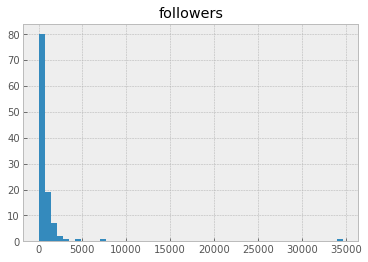

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv")

summum_popularity = pd.DataFrame(data.groupby('username').followers.max())
summum_popularity.hist(bins=50)

In [127]:
small=500
mid=2000
big=10000
summum_popularity['starhood']='none'
summum_popularity.loc[summum_popularity.followers<small,'starhood']='small'
summum_popularity.loc[(summum_popularity.followers>small) & (summum_popularity.followers<mid),'starhood']='mid'
summum_popularity.loc[(summum_popularity.followers>mid) & (summum_popularity.followers<big),'starhood']='large'
summum_popularity.loc[(summum_popularity.followers>big),'starhood']='very large'
data.set_index('username', inplace=True)
data['starhood']=summum_popularity.starhood
data.reset_index(inplace=True)

print(data.groupby('starhood').username.unique().apply(lambda x: x.size))

starhood
large          6
mid           31
small         74
very large     1
Name: username, dtype: int64


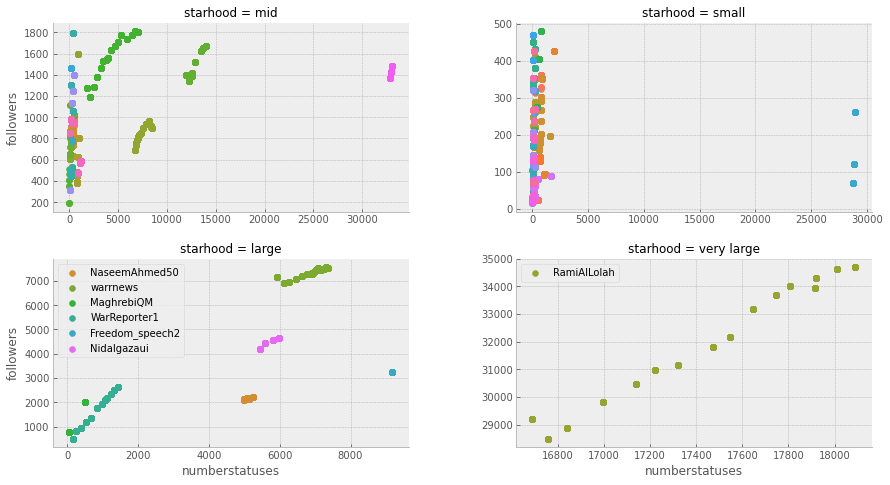

In [128]:
data[data.starhood=='large'].groupby('name').username.last()

data[data.starhood=='large'].groupby('name').username.last()

grid = sns.FacetGrid(data=data, col='starhood',col_wrap=2, hue='username', sharex=False, sharey=False)
grid=grid.map(plt.scatter,'numberstatuses','followers')
grid.axes[2].legend(loc='upper left')
grid.axes[3].legend(loc='upper left')
grid.fig.set_size_inches((14,7))

C:\Users\Dell\AppData\Local\Temp\ipykernel_6084\1082922652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rami_data.time=pd.to_datetime(rami_data.time)


<AxesSubplot:xlabel='time'>

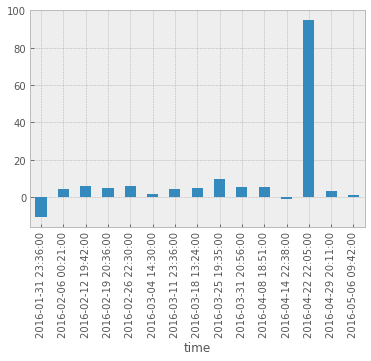

In [129]:
rami_data = data[data.username=='RamiAlLolah']
pd.to_datetime(rami_data.time)
rami_data.time=pd.to_datetime(rami_data.time)
rami_data.set_index('time', inplace=True)
impact = ((rami_data.followers-rami_data.followers.shift(-1))/(rami_data.numberstatuses-rami_data.numberstatuses.shift(-1))).dropna()
impact.plot(kind='bar')

In [130]:
for i in range(0, 6):
    print(rami_data[rami_data.index == impact.sort_values().index[-i]].tweets.to_numpy())

['He deserves the support.. https://t.co/SAGk95t7DV']
['#Photo Pilot of the SAA downed jet Azzam Eid from Hama who was captured by #ISIS after ejected from his jet.. #Syria https://t.co/sCMrfFqoAn']
['@edasa123 هههههههههه روح العب غيرها @MousaAlomar']
["This is happening every day now. 21 SAA militants killed; 3 tanks gone when #Assad's army approached #Mahin. #Syria https://t.co/qyghTqcwx8"]
['Ceasefire violations in #Syria as of now:\n#Talbiseh in #Homs\n#Daraa\nal-Marj near #Damascus\nnorth #Aleppo countryside https://t.co/5uKIqf3IMv']
["This well 'vetted/inspected' VSO mercenary main task is to guard #Turkey borders in Jarabulus-Azaz strip only #Syria https://t.co/MwdhVCY1Ad"]


social network cluster analysis
We extract each unique user by their username to act as a node. The username has been chosen as the associated data on each node as it is unique unlike names which might not be. The scale of the node will be influenced by the a combination of the number of followers and the number of tweets they produce. This combination will ensure that active and popular users are identified rather than identifying those who tweet a lot and have a small amount of followers or vice versa.

Currently the relation between each user is yet to be decided, as well as the number of followers, who those followers are would be useful to identify the relation between different users. One relation criteria might be to scrape the tweets of users for mentions and then link nodes via this metric with numerous mentions increasing the weight of an edge between two users. In this context two types of mentions could be identified, those that result in direct communication with a user and those mentions that come from retweeting a user. The former could be combined with language processing to determine the emotive qualities of the tweets to see if there are inner hostilities between ISIS supporters.

NetworkX is a useful graph library which allows for the visualization of graphs, its draw functions are directly linked to matplotlib allowing for similar looking visualizations to be created.

In [131]:
import networkx as nx
from collections import Counter
plt.style.use('ggplot')

dataset = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv")

The first interesting stat to find would be how many users in the dataset tweet each other? The first two print commands are to check that there are no duplicate tweets which would skew results. The only disadvantage is that this relies on an exact string match, if retweets have been preceeded by an RT then this would not pick up duplicates.

Using a regex expression we can catch those tweets that contain "RT" at the start of the tweet (indicating a retweet) and count them. Compared to the previous check we can see roughly 6000 tweets are not actually useful due to them being retweets. Despite this they are useful for future reference in testing what relation criteria to use.

Unique tweets: 17410
All tweets: 17410


[Text(1, 0, 'Actual Tweets'), Text(2, 0, 'Retweets')]

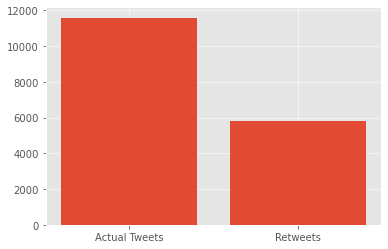

In [132]:
print("Unique tweets: {}".format(len(dataset['tweets'].unique())))
print("All tweets: {}".format(len(dataset['tweets'])))

retweets = []
actual_tweets = []
for user, tweet in zip(dataset['username'], dataset['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

Who talks about who?
Now we have seperated the retweets and actual tweets and grouped them with their usernames we can proceed to perform some analysis on who is talking about who!

Firstly we iterate through each tweetand scrape mentioned usernames from them (where the user isn't mentioning themself). These usernames are then determined to either be users from within tweets.csv or not within tweets.csv. It is clear to see from the below bar chart that the majority of users mentioned are outside the scope of the dataset. This opens up another avenue for producing the social graph where a graph of all users mentioned can be constructed with colour defining those that are known (within the dataset) and those that aren't known (not within the dataset). For now we'll focus on those contained only within the dataset as this is a smaller set of users to work with.

The second chart shows how many users in tweets.csv have been mentioned by other users within tweets.csv. There seems to be a reasonable amount of communication between the users but what this communication is, is yet to be seen.

Text(0.5, 1.0, 'Mentioned vs. Total in tweets.csv')

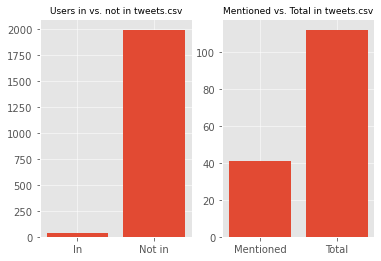

In [133]:
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in dataset['username'].unique()) and (record[0] != name[1:]):
                in_set.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

fig, ax = plt.subplots(1,2)

ax[0].bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center')
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['In', 'Not in'])
ax[0].set_title('Users in vs. not in tweets.csv', fontsize=9)

ax[1].bar([1,2], [len(np.unique(in_set[:,1])), len(dataset['username'].unique())], align='center')
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['Mentioned', 'Total'])
ax[1].set_title('Mentioned vs. Total in tweets.csv', fontsize=9)

To map out the most influential (most tweeted) users we need to count how many times they are mentioned. This is done via counting the in_set list, as can be seen below the most tweeted user currently is Rami.

Originally this cell stated that WarReporter1 was the most tweeted user but since removing tweets where the sender and receiver were the same user this has dropped drastically.

In [134]:
sender_count = Counter(in_set[:,0])
receiver_count = Counter(in_set[:,1])
top_5_senders = sender_count.most_common(5)
top_5_receivers = receiver_count.most_common(5)

print(top_5_senders)
print(top_5_receivers)

[('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)]
[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


What are these top 5 all about? By grabbing their descriptions we can see they are mostly "unbiased" news sites.

In [135]:
for name, _ in top_5_receivers:
    print("Username: {} - {}\n".format(name,
            dataset[dataset['username'] == name]['description'].dropna().unique()[0]))

Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



After going on a tangent and looking at "the top 5", let's map these "most tweeted" to a graph! So far the users have been sorted into three categories:

1 - Only senders (Red)

2 - Only receivers (Blue)

3 - Senders and Receivers (Green)

The next step will involve mapping edges between nodes where the users have tweeted each other, the edge thickness will depend on how many communications have been made.

In [136]:
pip install networkx

In [137]:
import networkx as nx

In [138]:
graph = nx.Graph()

all_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g')
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r')
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b')

Mentioned above, the next step is to build the weighted edges between users in the graph. The weight depends on the amount of tweets sent between two connected users, ideally this will be represented by a thicker edge for the increase in weight. Looking at the below graph we can see that there are a number of interesting exchanges between users (e.g. AsimAbuMerjem & MilkSheikh2 and moustiklash & _lshraqAhmad). Later analysis will take a look at these exchanges to see the nature of them. For the time being the task of altering the node size to reflect a combination of the number of tweets and followers is being pursued. This is proving tricky to find some mathematical function that will produce large values when tweet number and follower number grow together.

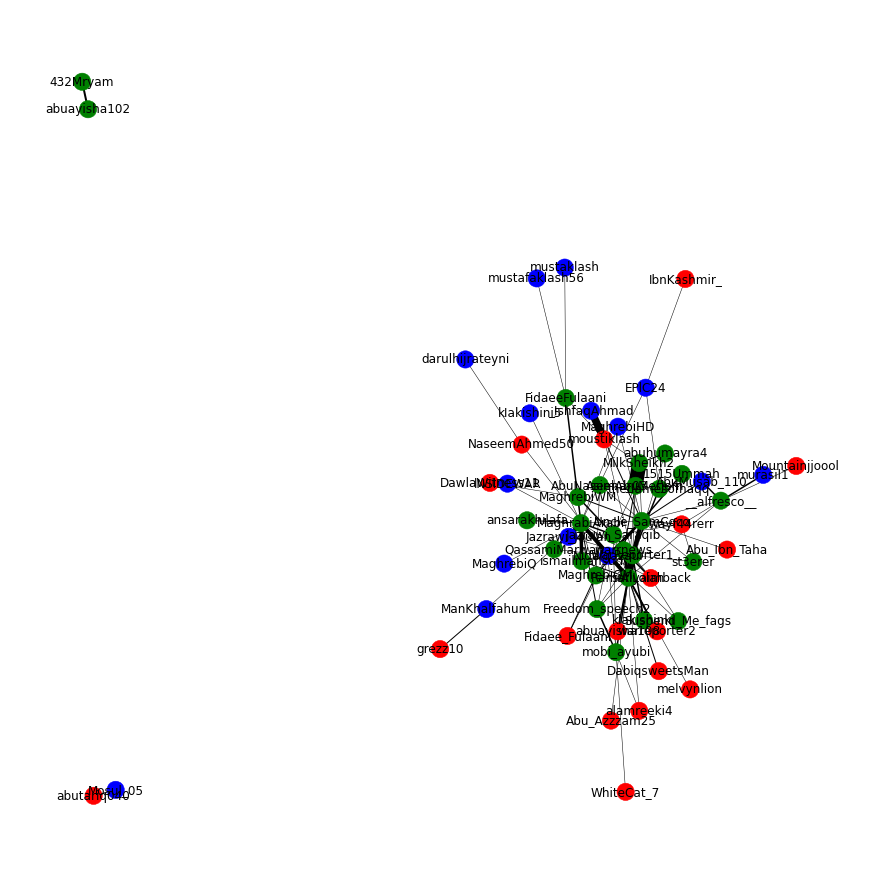

In [139]:
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = dataset[dataset['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = dataset[dataset['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]
weights = [0.5 * graph[u][v]['weight'] for u, v in graph.edges()]
#edge_width = [0.0015 * G[u][v]['weight'] for u, v in G.edges()]
#weights = [graph.edges[u][v]/2 for u, v in graph.edges()]

plt.figure(figsize=(12,12))
nx.draw(graph, pos=nx.spring_layout(graph),
        node_color=node_colours, with_labels=True, width=weights)
plt.show()

# Drawing network

In [140]:
index = []
for i in range(len(df['tweets'])):
    if '@' in df['tweets'][i]:
        index.append(i)
        
With_mention = df.iloc[index,:].reset_index(drop=True)
With_mention['Tagged_User'] = With_mention['tweets'].apply(lambda x: re.findall(r'@([A-Za-z0-9_]+)',str(x)))
User = With_mention['username'].unique()
With_mention['Tagged_User_Co'] = With_mention['Tagged_User'].apply(lambda x: list(set(x).intersection(User)) )
With_mention['Co_length'] = With_mention['Tagged_User_Co'].apply(lambda x: len(x))
With_mention_2 = With_mention[With_mention['Co_length']>0].reset_index(drop=True)

#### Isis Mentions Network
We first create a data frame which contains the information of individual tagging activities in each row.

In [146]:
for i in range(len(With_mention['tweets'])):
    frame = With_mention.iloc[i,:]
    for j in range(len(frame['Tagged_User'])):
        tmp = pd.DataFrame({'User':[frame['username']],'Mentions':[frame['Tagged_User'][j]],'Time': [frame['time']],'User_numberstatuses':[frame['numberstatuses']],'User_followers':[frame['followers']],'Weight': [1]})
        if i==0 and j==0:
            Mention_net = tmp
        else:
            #Mention_net = Mention_net.append(tmp, ignore_index=True)
            Mention_net = pd.concat([Mention_net, tmp])

#### A similar data frame will be created that only contains the interactivity between users in the data frame

In [148]:
for i in range(len(With_mention_2['tweets'])):
    frame = With_mention_2.iloc[i,:]
    for j in range(len(frame['Tagged_User_Co'])):
        Mentioned_follower = list(df[df['username']==frame['Tagged_User_Co'][j]]['followers'])[0]
        Mehtioned_statuses = list(df[df['username']==frame['Tagged_User_Co'][j]]['numberstatuses'])[0] 
        tmp = pd.DataFrame({'Mentioned_statuses':[Mehtioned_statuses],'Mentioned_followers':[Mentioned_follower],'User':[frame['username']],'Mentions':[frame['Tagged_User_Co'][j]],'Time': [frame['time']],'User_numberstatuses':[frame['numberstatuses']],'User_followers':[frame['followers']],'Weight': [1]})
        if i==0 and j==0:
            Mention_net_2 = tmp
        else:
            #Mention_net_2 = Mention_net_2.append(tmp, ignore_index=True)
            Mention_net_2 = pd.concat([Mention_net_2, tmp])
    
Mention_net = Mention_net[Mention_net['User']!=Mention_net['Mentions']]
Mention_net_2 = Mention_net_2[Mention_net_2['User']!=Mention_net_2['Mentions']]
Mention_net = Mention_net.reset_index(drop=True)
Mention_net_2 = Mention_net_2.reset_index(drop=True)
Mention_net.head(5)

,User,Mentions,Time,User_numberstatuses,User_followers,Weight
0,GunsandCoffee70,KhalidMaghrebi,2015-01-06 22:17:00,49,640,1
1,GunsandCoffee70,seifulmaslul123,2015-01-06 22:17:00,49,640,1
2,GunsandCoffee70,CheerLeadUnited,2015-01-06 22:17:00,49,640,1
3,GunsandCoffee70,KhalidMaghrebi,2015-01-10 00:08:00,49,640,1
4,GunsandCoffee70,seifulmaslul123,2015-01-10 00:08:00,49,640,1


#### In and out degree of network
It is insightful to see how many times a user mentions others and how many times a user is mentioned by the others. For targeting the potential terrorist, in and out degree on social media may be a helpful indicators.

In [149]:
In_degree = Mention_net.groupby(by=['Mentions'],as_index=False)['Weight'].sum()
Out_degree= Mention_net.groupby(by=['User'],as_index=False)['Weight'].sum()
In_degree = pd.DataFrame(In_degree).sort_values(by='Weight',ascending=False).reset_index(drop=True)
Out_degree = pd.DataFrame(Out_degree).sort_values(by='Weight',ascending=False).reset_index(drop=True)
print( 'Most mentioned user is '+str(In_degree['Mentions'][0])+' with ' + str(In_degree['Weight'][0])+' times mentioned by the other users.')
print( 'Most active user is '+str(Out_degree['User'][0])+' with ' + str(Out_degree['Weight'][0])+' times mentioning other users.')

Most mentioned user is RamiAlLolah with 565 times mentioned by the other users.
Most active user is Uncle_SamCoco with 1578 times mentioning other users.


#### In the second data frame where all users and tagged users are in the original data set, we can also see the names of most active and mentioned user.

In [150]:
In_degree_2 = Mention_net_2.groupby(by=['Mentions'],as_index=False)['Weight'].sum()
Out_degree_2= Mention_net_2.groupby(by=['User'],as_index=False)['Weight'].sum()
In_degree_2 = pd.DataFrame(In_degree_2).sort_values(by='Weight',ascending=False).reset_index(drop=True)
Out_degree_2 = pd.DataFrame(Out_degree_2).sort_values(by='Weight',ascending=False).reset_index(drop=True)
print( 'Most mentioned user is '+str(In_degree_2['Mentions'][0])+' with ' + str(In_degree['Weight'][0])+' times mentioned by the other users.')
print( 'Most active user is '+str(Out_degree_2['User'][0])+' with ' + str(Out_degree['Weight'][0])+' times mentioning other users.')

Most mentioned user is RamiAlLolah with 565 times mentioned by the other users.
Most active user is mobi_ayubi with 1578 times mentioning other users.


# TEMPORAL ANALYSIS

<AxesSubplot:>

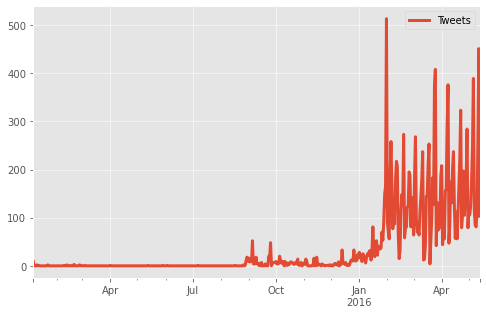

In [153]:
import datetime as dt
import matplotlib as mpl
from scipy import signal

#Plotting params
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 3
plt.style.use('ggplot')

#Dates are the second last column
df = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv", parse_dates = [-2])

def f(x): 
    
    return dt.datetime(x.year,x.month,x.day)

df['time'] = df.time.apply( f)

time_series = pd.DataFrame(df.time.value_counts().sort_index().resample('D').mean().fillna(0))
time_series.columns = ['Tweets']

time_series.plot()

#### JANUARY

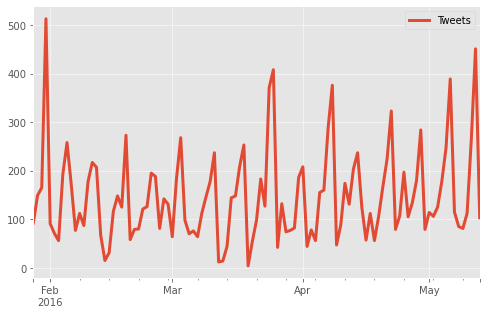

In [156]:
time_series = time_series.loc['2016-01-28':]
time_series.plot()
ts = time_series.values.ravel()

#### There are instances where there are more than 400 tweets on some days, and almost 0 on others.
We use tools from singal processing to examine the frequency.

Text(0.5, 0, 'No. of Days')

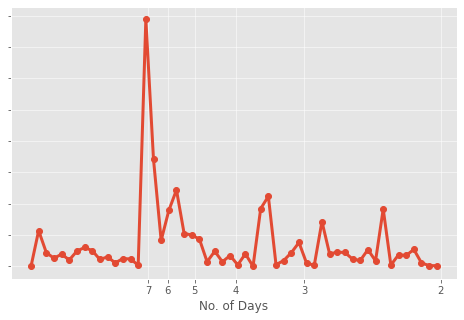

In [157]:
fs = np.fft.fftfreq(np.arange(len(ts)).shape[-1])
x,y = signal.periodogram(ts)
plt.plot(x,y,'o-')

oneov = [1.0/j for j in range(2,8)]
plt.xticks(oneov,range(2,8))
ax = plt.gca()


ax.grid(True)
ax.set_yticklabels([])
ax.set_xlabel('No. of Days')


This is a Periodogram, which tells us which frequency is the largest contrinutor. The x axis is typically in 1/Days, so here, I have labeled where 2 through 7 days would lie on the x axis.

Wow, seems as if there is a big spike at 7. This suggests every 7 days, a mass amount of tweets is made. Lets try and figure on what weekday these tweets are made.

We will first need to find the places where the peaks occur. Luckily, scipy has a function for that.

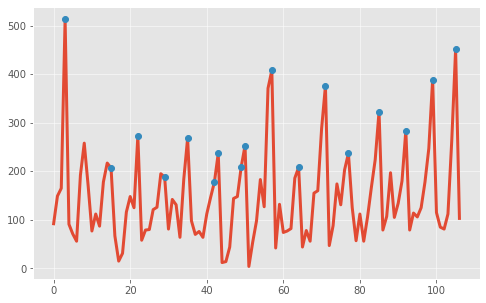

In [158]:
p = signal.find_peaks_cwt(ts, np.arange(1,4) )


t = np.arange(len(ts))
plt.plot(t,ts)
plt.plot(t[p],ts[p],'o')

In [161]:
r = time_series.iloc[p].reset_index().copy()

r.columns = ['date','tweet']

r['weekday'] = r.date.apply(lambda x: x.weekday())

r.weekday.value_counts()

4    11
3     5
6     1
Name: weekday, dtype: int64


The .weekday() function returns a number for the correpsonding weekday. 0 is monday, 6 is sunday, which means that 4 is Friday.

This shouldn't be a huge surprise. Every friday, Muslims hold a congressional prayer known as Jumu'ah.

# Time series

ConversionError: Failed to convert value(s) to axis units: array([Period('2015-01-06', 'D'), Period('2015-01-07', 'D'),
       Period('2015-01-08', 'D'), Period('2015-01-09', 'D'),
       Period('2015-01-10', 'D'), Period('2015-01-11', 'D'),
       Period('2015-01-12', 'D'), Period('2015-01-13', 'D'),
       Period('2015-01-14', 'D'), Period('2015-01-15', 'D'),
       Period('2015-01-16', 'D'), Period('2015-01-17', 'D'),
       Period('2015-01-18', 'D'), Period('2015-01-19', 'D'),
       Period('2015-01-20', 'D'), Period('2015-01-21', 'D'),
       Period('2015-01-22', 'D'), Period('2015-01-23', 'D'),
       Period('2015-01-24', 'D'), Period('2015-01-25', 'D'),
       Period('2015-01-26', 'D'), Period('2015-01-27', 'D'),
       Period('2015-01-28', 'D'), Period('2015-01-29', 'D'),
       Period('2015-01-30', 'D'), Period('2015-01-31', 'D'),
       Period('2015-02-01', 'D'), Period('2015-02-02', 'D'),
       Period('2015-02-03', 'D'), Period('2015-02-04', 'D'),
       Period('2015-02-05', 'D'), Period('2015-02-06', 'D'),
       Period('2015-02-07', 'D'), Period('2015-02-08', 'D'),
       Period('2015-02-09', 'D'), Period('2015-02-10', 'D'),
       Period('2015-02-11', 'D'), Period('2015-02-12', 'D'),
       Period('2015-02-13', 'D'), Period('2015-02-14', 'D'),
       Period('2015-02-15', 'D'), Period('2015-02-16', 'D'),
       Period('2015-02-17', 'D'), Period('2015-02-18', 'D'),
       Period('2015-02-19', 'D'), Period('2015-02-20', 'D'),
       Period('2015-02-21', 'D'), Period('2015-02-22', 'D'),
       Period('2015-02-23', 'D'), Period('2015-02-24', 'D'),
       Period('2015-02-25', 'D'), Period('2015-02-26', 'D'),
       Period('2015-02-27', 'D'), Period('2015-02-28', 'D'),
       Period('2015-03-01', 'D'), Period('2015-03-02', 'D'),
       Period('2015-03-03', 'D'), Period('2015-03-04', 'D'),
       Period('2015-03-05', 'D'), Period('2015-03-06', 'D'),
       Period('2015-03-07', 'D'), Period('2015-03-08', 'D'),
       Period('2015-03-09', 'D'), Period('2015-03-10', 'D'),
       Period('2015-03-11', 'D'), Period('2015-03-12', 'D'),
       Period('2015-03-13', 'D'), Period('2015-03-14', 'D'),
       Period('2015-03-15', 'D'), Period('2015-03-16', 'D'),
       Period('2015-03-17', 'D'), Period('2015-03-18', 'D'),
       Period('2015-03-19', 'D'), Period('2015-03-20', 'D'),
       Period('2015-03-21', 'D'), Period('2015-03-22', 'D'),
       Period('2015-03-23', 'D'), Period('2015-03-24', 'D'),
       Period('2015-03-25', 'D'), Period('2015-03-26', 'D'),
       Period('2015-03-27', 'D'), Period('2015-03-28', 'D'),
       Period('2015-03-29', 'D'), Period('2015-03-30', 'D'),
       Period('2015-03-31', 'D'), Period('2015-04-01', 'D'),
       Period('2015-04-02', 'D'), Period('2015-04-03', 'D'),
       Period('2015-04-04', 'D'), Period('2015-04-05', 'D'),
       Period('2015-04-06', 'D'), Period('2015-04-07', 'D'),
       Period('2015-04-08', 'D'), Period('2015-04-09', 'D'),
       Period('2015-04-10', 'D'), Period('2015-04-11', 'D'),
       Period('2015-04-12', 'D'), Period('2015-04-13', 'D'),
       Period('2015-04-14', 'D'), Period('2015-04-15', 'D'),
       Period('2015-04-16', 'D'), Period('2015-04-17', 'D'),
       Period('2015-04-18', 'D'), Period('2015-04-19', 'D'),
       Period('2015-04-20', 'D'), Period('2015-04-21', 'D'),
       Period('2015-04-22', 'D'), Period('2015-04-23', 'D'),
       Period('2015-04-24', 'D'), Period('2015-04-25', 'D'),
       Period('2015-04-26', 'D'), Period('2015-04-27', 'D'),
       Period('2015-04-28', 'D'), Period('2015-04-29', 'D'),
       Period('2015-04-30', 'D'), Period('2015-05-01', 'D'),
       Period('2015-05-02', 'D'), Period('2015-05-03', 'D'),
       Period('2015-05-04', 'D'), Period('2015-05-05', 'D'),
       Period('2015-05-06', 'D'), Period('2015-05-07', 'D'),
       Period('2015-05-08', 'D'), Period('2015-05-09', 'D'),
       Period('2015-05-10', 'D'), Period('2015-05-11', 'D'),
       Period('2015-05-12', 'D'), Period('2015-05-13', 'D'),
       Period('2015-05-14', 'D'), Period('2015-05-15', 'D'),
       Period('2015-05-16', 'D'), Period('2015-05-17', 'D'),
       Period('2015-05-18', 'D'), Period('2015-05-19', 'D'),
       Period('2015-05-20', 'D'), Period('2015-05-21', 'D'),
       Period('2015-05-22', 'D'), Period('2015-05-23', 'D'),
       Period('2015-05-24', 'D'), Period('2015-05-25', 'D'),
       Period('2015-05-26', 'D'), Period('2015-05-27', 'D'),
       Period('2015-05-28', 'D'), Period('2015-05-29', 'D'),
       Period('2015-05-30', 'D'), Period('2015-05-31', 'D'),
       Period('2015-06-01', 'D'), Period('2015-06-02', 'D'),
       Period('2015-06-03', 'D'), Period('2015-06-04', 'D'),
       Period('2015-06-05', 'D'), Period('2015-06-06', 'D'),
       Period('2015-06-07', 'D'), Period('2015-06-08', 'D'),
       Period('2015-06-09', 'D'), Period('2015-06-10', 'D'),
       Period('2015-06-11', 'D'), Period('2015-06-12', 'D'),
       Period('2015-06-13', 'D'), Period('2015-06-14', 'D'),
       Period('2015-06-15', 'D'), Period('2015-06-16', 'D'),
       Period('2015-06-17', 'D'), Period('2015-06-18', 'D'),
       Period('2015-06-19', 'D'), Period('2015-06-20', 'D'),
       Period('2015-06-21', 'D'), Period('2015-06-22', 'D'),
       Period('2015-06-23', 'D'), Period('2015-06-24', 'D'),
       Period('2015-06-25', 'D'), Period('2015-06-26', 'D'),
       Period('2015-06-27', 'D'), Period('2015-06-28', 'D'),
       Period('2015-06-29', 'D'), Period('2015-06-30', 'D'),
       Period('2015-07-01', 'D'), Period('2015-07-02', 'D'),
       Period('2015-07-03', 'D'), Period('2015-07-04', 'D'),
       Period('2015-07-05', 'D'), Period('2015-07-06', 'D'),
       Period('2015-07-07', 'D'), Period('2015-07-08', 'D'),
       Period('2015-07-09', 'D'), Period('2015-07-10', 'D'),
       Period('2015-07-11', 'D'), Period('2015-07-12', 'D'),
       Period('2015-07-13', 'D'), Period('2015-07-14', 'D'),
       Period('2015-07-15', 'D'), Period('2015-07-16', 'D'),
       Period('2015-07-17', 'D'), Period('2015-07-18', 'D'),
       Period('2015-07-19', 'D'), Period('2015-07-20', 'D'),
       Period('2015-07-21', 'D'), Period('2015-07-22', 'D'),
       Period('2015-07-23', 'D'), Period('2015-07-24', 'D'),
       Period('2015-07-25', 'D'), Period('2015-07-26', 'D'),
       Period('2015-07-27', 'D'), Period('2015-07-28', 'D'),
       Period('2015-07-29', 'D'), Period('2015-07-30', 'D'),
       Period('2015-07-31', 'D'), Period('2015-08-01', 'D'),
       Period('2015-08-02', 'D'), Period('2015-08-03', 'D'),
       Period('2015-08-04', 'D'), Period('2015-08-05', 'D'),
       Period('2015-08-06', 'D'), Period('2015-08-07', 'D'),
       Period('2015-08-08', 'D'), Period('2015-08-09', 'D'),
       Period('2015-08-10', 'D'), Period('2015-08-11', 'D'),
       Period('2015-08-12', 'D'), Period('2015-08-13', 'D'),
       Period('2015-08-14', 'D'), Period('2015-08-15', 'D'),
       Period('2015-08-16', 'D'), Period('2015-08-17', 'D'),
       Period('2015-08-18', 'D'), Period('2015-08-19', 'D'),
       Period('2015-08-20', 'D'), Period('2015-08-21', 'D'),
       Period('2015-08-22', 'D'), Period('2015-08-23', 'D'),
       Period('2015-08-24', 'D'), Period('2015-08-25', 'D'),
       Period('2015-08-26', 'D'), Period('2015-08-27', 'D'),
       Period('2015-08-28', 'D'), Period('2015-08-29', 'D'),
       Period('2015-08-30', 'D'), Period('2015-08-31', 'D'),
       Period('2015-09-01', 'D'), Period('2015-09-02', 'D'),
       Period('2015-09-03', 'D'), Period('2015-09-04', 'D'),
       Period('2015-09-05', 'D'), Period('2015-09-06', 'D'),
       Period('2015-09-07', 'D'), Period('2015-09-08', 'D'),
       Period('2015-09-09', 'D'), Period('2015-09-10', 'D'),
       Period('2015-09-11', 'D'), Period('2015-09-12', 'D'),
       Period('2015-09-13', 'D'), Period('2015-09-14', 'D'),
       Period('2015-09-15', 'D'), Period('2015-09-16', 'D'),
       Period('2015-09-17', 'D'), Period('2015-09-18', 'D'),
       Period('2015-09-19', 'D'), Period('2015-09-20', 'D'),
       Period('2015-09-21', 'D'), Period('2015-09-22', 'D'),
       Period('2015-09-23', 'D'), Period('2015-09-24', 'D'),
       Period('2015-09-25', 'D'), Period('2015-09-26', 'D'),
       Period('2015-09-27', 'D'), Period('2015-09-28', 'D'),
       Period('2015-09-29', 'D'), Period('2015-09-30', 'D'),
       Period('2015-10-01', 'D'), Period('2015-10-02', 'D'),
       Period('2015-10-03', 'D'), Period('2015-10-04', 'D'),
       Period('2015-10-05', 'D'), Period('2015-10-06', 'D'),
       Period('2015-10-07', 'D'), Period('2015-10-08', 'D'),
       Period('2015-10-09', 'D'), Period('2015-10-10', 'D'),
       Period('2015-10-11', 'D'), Period('2015-10-12', 'D'),
       Period('2015-10-13', 'D'), Period('2015-10-14', 'D'),
       Period('2015-10-15', 'D'), Period('2015-10-16', 'D'),
       Period('2015-10-17', 'D'), Period('2015-10-18', 'D'),
       Period('2015-10-19', 'D'), Period('2015-10-20', 'D'),
       Period('2015-10-21', 'D'), Period('2015-10-22', 'D'),
       Period('2015-10-23', 'D'), Period('2015-10-24', 'D'),
       Period('2015-10-25', 'D'), Period('2015-10-26', 'D'),
       Period('2015-10-27', 'D'), Period('2015-10-28', 'D'),
       Period('2015-10-29', 'D'), Period('2015-10-30', 'D'),
       Period('2015-10-31', 'D'), Period('2015-11-01', 'D'),
       Period('2015-11-02', 'D'), Period('2015-11-03', 'D'),
       Period('2015-11-04', 'D'), Period('2015-11-05', 'D'),
       Period('2015-11-06', 'D'), Period('2015-11-07', 'D'),
       Period('2015-11-08', 'D'), Period('2015-11-09', 'D'),
       Period('2015-11-10', 'D'), Period('2015-11-11', 'D'),
       Period('2015-11-12', 'D'), Period('2015-11-13', 'D'),
       Period('2015-11-14', 'D'), Period('2015-11-15', 'D'),
       Period('2015-11-16', 'D'), Period('2015-11-17', 'D'),
       Period('2015-11-18', 'D'), Period('2015-11-19', 'D'),
       Period('2015-11-20', 'D'), Period('2015-11-21', 'D'),
       Period('2015-11-22', 'D'), Period('2015-11-23', 'D'),
       Period('2015-11-24', 'D'), Period('2015-11-25', 'D'),
       Period('2015-11-26', 'D'), Period('2015-11-27', 'D'),
       Period('2015-11-28', 'D'), Period('2015-11-29', 'D'),
       Period('2015-11-30', 'D'), Period('2015-12-01', 'D'),
       Period('2015-12-02', 'D'), Period('2015-12-03', 'D'),
       Period('2015-12-04', 'D'), Period('2015-12-05', 'D'),
       Period('2015-12-06', 'D'), Period('2015-12-07', 'D'),
       Period('2015-12-08', 'D'), Period('2015-12-09', 'D'),
       Period('2015-12-10', 'D'), Period('2015-12-11', 'D'),
       Period('2015-12-12', 'D'), Period('2015-12-13', 'D'),
       Period('2015-12-14', 'D'), Period('2015-12-15', 'D'),
       Period('2015-12-16', 'D'), Period('2015-12-17', 'D'),
       Period('2015-12-18', 'D'), Period('2015-12-19', 'D'),
       Period('2015-12-20', 'D'), Period('2015-12-21', 'D'),
       Period('2015-12-22', 'D'), Period('2015-12-23', 'D'),
       Period('2015-12-24', 'D'), Period('2015-12-25', 'D'),
       Period('2015-12-26', 'D'), Period('2015-12-27', 'D'),
       Period('2015-12-28', 'D'), Period('2015-12-29', 'D'),
       Period('2015-12-30', 'D'), Period('2015-12-31', 'D'),
       Period('2016-01-01', 'D'), Period('2016-01-02', 'D'),
       Period('2016-01-03', 'D'), Period('2016-01-04', 'D'),
       Period('2016-01-05', 'D'), Period('2016-01-06', 'D'),
       Period('2016-01-07', 'D'), Period('2016-01-08', 'D'),
       Period('2016-01-09', 'D'), Period('2016-01-10', 'D'),
       Period('2016-01-11', 'D'), Period('2016-01-12', 'D'),
       Period('2016-01-13', 'D'), Period('2016-01-14', 'D'),
       Period('2016-01-15', 'D'), Period('2016-01-16', 'D'),
       Period('2016-01-17', 'D'), Period('2016-01-18', 'D'),
       Period('2016-01-19', 'D'), Period('2016-01-20', 'D'),
       Period('2016-01-21', 'D'), Period('2016-01-22', 'D'),
       Period('2016-01-23', 'D'), Period('2016-01-24', 'D'),
       Period('2016-01-25', 'D'), Period('2016-01-26', 'D'),
       Period('2016-01-27', 'D'), Period('2016-01-28', 'D'),
       Period('2016-01-29', 'D'), Period('2016-01-30', 'D'),
       Period('2016-01-31', 'D'), Period('2016-02-01', 'D'),
       Period('2016-02-02', 'D'), Period('2016-02-03', 'D'),
       Period('2016-02-04', 'D'), Period('2016-02-05', 'D'),
       Period('2016-02-06', 'D'), Period('2016-02-07', 'D'),
       Period('2016-02-08', 'D'), Period('2016-02-09', 'D'),
       Period('2016-02-10', 'D'), Period('2016-02-11', 'D'),
       Period('2016-02-12', 'D'), Period('2016-02-13', 'D'),
       Period('2016-02-14', 'D'), Period('2016-02-15', 'D'),
       Period('2016-02-16', 'D'), Period('2016-02-17', 'D'),
       Period('2016-02-18', 'D'), Period('2016-02-19', 'D'),
       Period('2016-02-20', 'D'), Period('2016-02-21', 'D'),
       Period('2016-02-22', 'D'), Period('2016-02-23', 'D'),
       Period('2016-02-24', 'D'), Period('2016-02-25', 'D'),
       Period('2016-02-26', 'D'), Period('2016-02-27', 'D'),
       Period('2016-02-28', 'D'), Period('2016-02-29', 'D'),
       Period('2016-03-01', 'D'), Period('2016-03-02', 'D'),
       Period('2016-03-03', 'D'), Period('2016-03-04', 'D'),
       Period('2016-03-05', 'D'), Period('2016-03-06', 'D'),
       Period('2016-03-07', 'D'), Period('2016-03-08', 'D'),
       Period('2016-03-09', 'D'), Period('2016-03-10', 'D'),
       Period('2016-03-11', 'D'), Period('2016-03-12', 'D'),
       Period('2016-03-13', 'D'), Period('2016-03-14', 'D'),
       Period('2016-03-15', 'D'), Period('2016-03-16', 'D'),
       Period('2016-03-17', 'D'), Period('2016-03-18', 'D'),
       Period('2016-03-19', 'D'), Period('2016-03-20', 'D'),
       Period('2016-03-21', 'D'), Period('2016-03-22', 'D'),
       Period('2016-03-23', 'D'), Period('2016-03-24', 'D'),
       Period('2016-03-25', 'D'), Period('2016-03-26', 'D'),
       Period('2016-03-27', 'D'), Period('2016-03-28', 'D'),
       Period('2016-03-29', 'D'), Period('2016-03-30', 'D'),
       Period('2016-03-31', 'D'), Period('2016-04-01', 'D'),
       Period('2016-04-02', 'D'), Period('2016-04-03', 'D'),
       Period('2016-04-04', 'D'), Period('2016-04-05', 'D'),
       Period('2016-04-06', 'D'), Period('2016-04-07', 'D'),
       Period('2016-04-08', 'D'), Period('2016-04-09', 'D'),
       Period('2016-04-10', 'D'), Period('2016-04-11', 'D'),
       Period('2016-04-12', 'D'), Period('2016-04-13', 'D'),
       Period('2016-04-14', 'D'), Period('2016-04-15', 'D'),
       Period('2016-04-16', 'D'), Period('2016-04-17', 'D'),
       Period('2016-04-18', 'D'), Period('2016-04-19', 'D'),
       Period('2016-04-20', 'D'), Period('2016-04-21', 'D'),
       Period('2016-04-22', 'D'), Period('2016-04-23', 'D'),
       Period('2016-04-24', 'D'), Period('2016-04-25', 'D'),
       Period('2016-04-26', 'D'), Period('2016-04-27', 'D'),
       Period('2016-04-28', 'D'), Period('2016-04-29', 'D'),
       Period('2016-04-30', 'D'), Period('2016-05-01', 'D'),
       Period('2016-05-02', 'D'), Period('2016-05-03', 'D'),
       Period('2016-05-04', 'D'), Period('2016-05-05', 'D'),
       Period('2016-05-06', 'D'), Period('2016-05-07', 'D'),
       Period('2016-05-08', 'D'), Period('2016-05-09', 'D'),
       Period('2016-05-10', 'D'), Period('2016-05-11', 'D'),
       Period('2016-05-12', 'D'), Period('2016-05-13', 'D')], dtype=object)

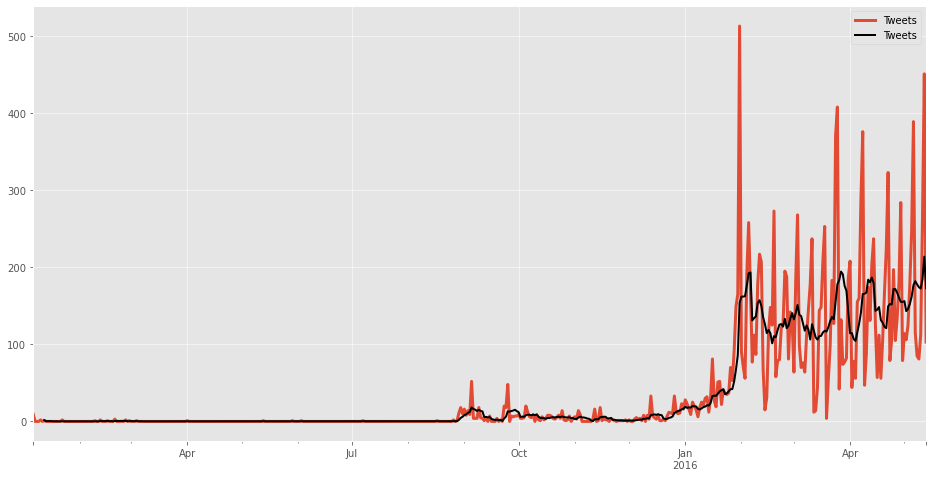

In [162]:
def f(x): 
    
    return dt.datetime(x.year,x.month,x.day)

df['time'] = df.time.apply( f)

time_series = pd.DataFrame(df.time.value_counts().sort_index().resample('D').mean().fillna(0))
time_series.columns = ['Tweets']
#How many tweets on each day.  Resample to get missing days

fig, ax = plt.subplots(figsize = (16,8))

time_series.plot(ax = ax)

time_series.rolling(window=7).mean().plot(ax = ax, linewidth = 2,color = 'k')


brussels = '2016-03-22'
paris = '2015-11-13'


ax.plot(brussels,183,color = 'w',
        marker = 'v',
        markersize = 12, 
        linestyle = '',
       markeredgewidth = 2
       )

ax.plot(paris,0,color = 'w',
        marker = 'o',
        markersize = 12, 
        linestyle = '',
        markeredgewidth = 2
        )




ax.margins(None,0.1)
ax.legend(['Tweets Made','Rolling 7 Day Mean', 'Bombing in Brussels','Shooting in Paris'], loc = 'upper left', numpoints = 1)
ax.set_xlabel('Date')
ax.set_ylabel('No of Tweets')

In [163]:
import csv
import os
import numpy
import copy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
folder_path = 'your/directory/path'

#plotting params
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 3
plt.style.use('ggplot')

#### LOAD AND CLEAN TWEETS

In [164]:
df = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv", parse_dates= [6])
df.username = df.username.str.lower()
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
def clean_tweet(tweet):
    ext = "http"
    text = tweet[:tweet.find(ext)].lower()
    text = re.sub("[^\S]", " ", text)
    text = re.sub("english translation ", "", text)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", text)
    return(textOnly)
def remove_users(tweet):
    text = tweet.lower()
    textOnly = re.sub(r"@\w+", "", text)
    return(textOnly)
df.tweets = df.tweets.apply(clean_tweet)

Currently we have occurences of usernames (twitter handles) in all tweets (original tweets and mentions). We only want original tweets so we can determine who is having an influence on who. This does not mean that we should remove all retweets, but rather extract those retweets and treat them as new tweets from new users.

We would like to extract every retweet from a given user and reassign that tweet to the first handle in that text string.

For example: "RT @GIIMedia_CH004: Rules Of Imarah Part2 - Conditions of Imamah" would create@GIIMedia_CH004 as a new user and assign everything after his/her handle in the text string as a tweet for that user.
We need to create a dictionary for every user with,

every user they have mentioned (affiliates),
every hashtag they have used and
every tweet they've sent
consolidate every tweet for every user into one document and add it to their dictionary

In [165]:
infoDict = OrderedDict()
for r in df[['username','tweets']].iterrows():
    match = re.search('^rt', r[1][1])
    if match:
        m = list(re.findall(r"@\w+", r[1][1]))
        if m:
            username=m[0][1:]
            tweet=r[1][1][len('rt ' + m[0]):] +' @' + r[1][0]
    else:
        username=r[1][0]
        tweet=r[1][1]
    if username not in infoDict:
        user = {}
        user['affil'] = []
        user['hashtags'] = []
        user['tweets'] = []
        user['doc'] = ''
        infoDict[username] = user
    if tweet not in infoDict[username]['tweets']:
        infoDict[username]['tweets'].append(tweet)
        infoDict[username]['doc']+=' ' + tweet
    infoDict[username]['hashtags'].extend(re.findall('(?<=#)\w+', tweet))
    infoDict[username]['affil'].extend(re.findall('(?<=@)\w+', tweet))
print('We went from 112 unique users to', len(infoDict), 'users') 

We went from 112 unique users to 1556 users


#### Treat all the tweets from one user as a single document and vectorize

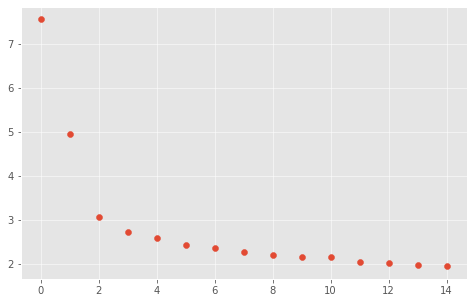

In [166]:
docs = [remove_users(v['doc']) for k, v in infoDict.items()]
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize,
                                  ngram_range=(1,1), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_docs = Tfidf_vectorizer.fit_transform(docs)
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1,3), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
cv_tweets = count_vectorizer.fit_transform(docs)
#treat each tweets seperately
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize,
                                  ngram_range=(1,2), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_tweets = Tfidf_vectorizer.fit_transform(df.tweets)
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(tfidf_docs, n_components=15,
                                      n_iter=5,
                                      random_state=None)
sigma = []
for k,v in enumerate(Sigma):
    sigma.append((k,v))
f = plt.scatter(*zip(*sigma))

Based on the sigma values from the resulting matrix we can choose about 6 components to use in our NMF model

#### NMF decomposition

In [167]:
tfidf_docs.shape

(1556, 22480)

In [168]:
num_topics = 6
model = NMF(n_components=num_topics, init='random', random_state=0)
nmf = model.fit_transform(tfidf_docs)
doc_cluster = [list(r).index(max(r)) for r in nmf]
print (doc_cluster[0:20])
print (doc_cluster[41:60])
print (doc_cluster[61:80])
print( doc_cluster[-40:-20])

[1, 3, 0, 1, 1, 2, 0, 4, 0, 1, 3, 0, 4, 4, 1, 1, 4, 0, 4, 1]
[0, 3, 1, 1, 1, 1, 4, 1, 0, 3, 2, 1, 0, 1, 1, 2, 4, 3, 4]
[3, 1, 1, 2, 2, 1, 3, 0, 2, 3, 1, 0, 1, 5, 1, 3, 3, 4, 1]
[1, 0, 3, 0, 0, 2, 2, 0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 2]


In [169]:
cluster_size = [0,0,0,0,0,0]
for v in doc_cluster:
    cluster_size[v]+=1
cluster_size

[237, 565, 154, 361, 165, 74]

In [170]:
data = pd.DataFrame(infoDict).T
data.reset_index(inplace=True)
data['cluster'] = doc_cluster
# create dictionary that maps a user to their specific cluster
user_docs = {}
for k, cluster in enumerate(doc_cluster):
    user_docs[data['index'][k]] = cluster
words = sorted([(i,v) for v,i in Tfidf_vectorizer.vocabulary_.items()])
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])
# Create the a list of topic words but only inlude them if they are the highest among all clusters
# they also need to be weighted appropriately within their cluster


word_cluster = [(list(r).index(max(r)),max(r)) for r in model.components_.transpose()]
for i,r in enumerate(model.components_.transpose()):
    s = sorted(r)
    if (s[0]-s[1])/s[1]<0.25:
        word_cluster[i] = (-1,-1)
topic_words = []
for c in range(6):
    a = sorted([(v[1],i) for i,v in enumerate(word_cluster) if v[0]==c], reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])
topic_words

C:\Users\Dell\AppData\Local\Temp\ipykernel_6084\3796107253.py:20: RuntimeWarning: invalid value encountered in double_scalars
  if (s[0]-s[1])/s[1]<0.25:


[[(982, '#aqsa meet'),
  (950, '#april'),
  (193, '#advance'),
  (419, '#aleppo lord'),
  (2698, '#fallujah #teenchoice'),
  (13810, '@1oeufquiparle reel'),
  (689, '#amaq 1300')],
 [(3747, '#iraq town'),
  (9718, '#wilayatalkhayr maryrdom'),
  (14719, '@adelani0la yes'),
  (8358, '#sultans'),
  (14708, '@adamks'),
  (12580, '38 mention'),
  (11920, '23 5')],
 [(19481, '@kesisygegum remember'),
  (11926, '23 days'),
  (3919, '#is assad'),
  (12834, '44'),
  (14092, '@a5barsy1'),
  (13223, '6 soldiers'),
  (22001, '@osamahfakih explosions')],
 [(12708, '4 siege'),
  (11902, '221'),
  (20607, '@mehdith2'),
  (19968, '@lightepisodesss'),
  (5892, '#lybia expanding'),
  (22334, '@proj000 subhanallah'),
  (4698, '#isis tanf')],
 [(1886, '#brussels attac'),
  (961, '#aqap fled'),
  (108, '#aamaq #lebanon'),
  (267, '#aircraft'),
  (1645, '#breaking 11'),
  (1467, '#basra #iraq'),
  (935, '#ansardine')],
 [(0, '#'),
  (2261, '#daraa city'),
  (9, '# 1'),
  (15304, '@alperboler'),
  (2479, '#d

#### CREATE GRAPH

In [171]:
def is_retweet(tweet):
    match = re.search('^rt', tweet)
    if match:
        return True
    return False

def check_string(string):
    return string in df.username.unique()
# number of retweets

count=0
rt = []
for tweet in df.tweets:
    m = re.findall(r"^rt @", tweet)
    if m:
        count+=1
        rt.append(tweet)
count
#len(set(rt))

5824

In [172]:
# create the nodes for the graph. Dictionary keys as usernames 
# with each item in the value list being a connection with number of times mentioned for every mentioned user

nodes = defaultdict(str)
for K, V in infoDict.items():
    nodes[K] = [(k, v) for k,v in Counter(list(V['affil'])).items() if k != K]
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]
matches = 0
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]
        
    for i in range(len(v)):
        if v[i][0] == k:
            matches+=1
            v.remove(v[i])
#create dictionary that maps usernames to a uniqe ID and the cluster they belong to
# user_docs = a list of documents per user

ID = defaultdict()
for k, v in enumerate(list(nodes.items())):
    ID[v[0]] = k, user_docs[v[0]]
    for i in range(0, len(v[1])):
        try:
            ID[v[1][i][0]] = k, user_docs[v[1][i][0]]
        except:
            pass
df2 = pd.DataFrame(ID).T

edge_dict = {}
for k, v in nodes.items():
    for i in range(len(v)):
        try:
            edge_dict[ID[[k][0]][0], ID[v[i][0]][0]] = v[i][1]
        except:
            pass

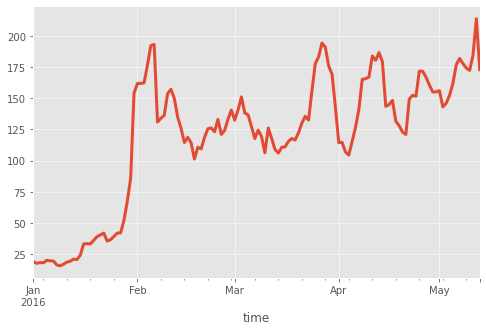

In [173]:
from scipy import interpolate
import seaborn as sns

df.time = pd.to_datetime(df.time)
perhr = df.set_index(df['time']).resample('D').agg('count')
#pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot()
moving_avg = perhr.rolling(7).mean().tweets['2016-01-01':].plot()

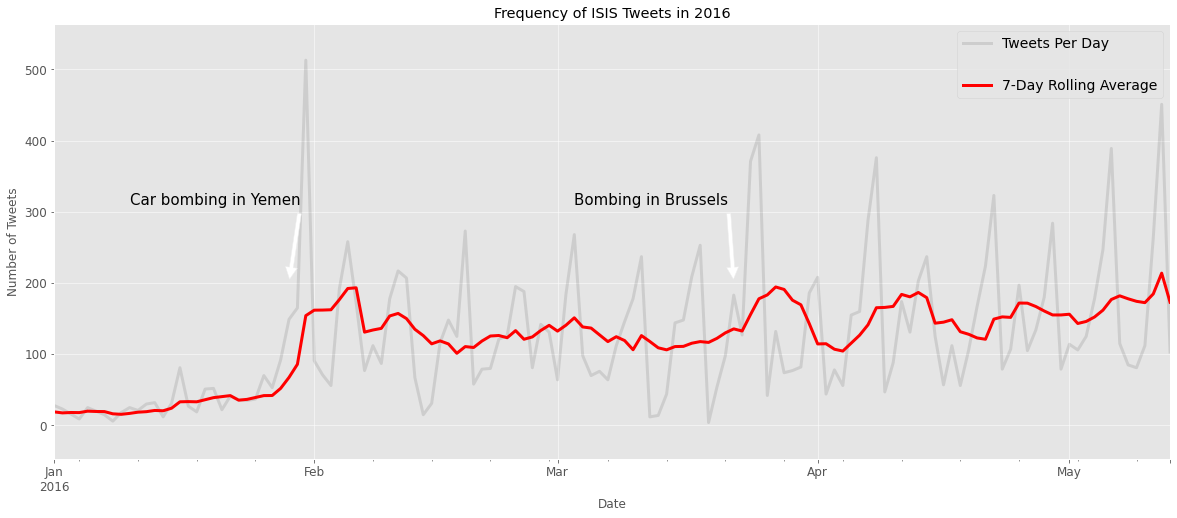

In [174]:
fig, ax = plt.subplots(figsize = (20,8))

perhr['2016-01-01':].numberstatuses.interpolate(method='linear').plot(ax = ax, color="black", fontsize=12, alpha=0.1)
#pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot(color ='r')
perhr.rolling(7).mean().tweets['2016-01-01':].plot(color='r')
#sns.timeseries(perhr, ax=ax)

yemen = '2016-01-29'
brussels = '2016-03-22'


ax.annotate('Bombing in Brussels',xy=(brussels, 200),xytext=('2016-03-03', 310),
            arrowprops=dict(facecolor='white', shrink=0.05), size=15)

ax.annotate('Car bombing in Yemen',xy=(yemen, 200),xytext=('2016-01-10', 310),
            arrowprops=dict(facecolor='white', shrink=0.05),size=15)

ax.margins(None,0.1)
ax.legend(['Tweets Per Day','7-Day Rolling Average'], loc = 'upper right',
           numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Frequency of ISIS Tweets in 2016')

# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w') 
# ax.spines['right'].set_color('w')
# ax.spines['left'].set_color('w')

# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')

# ax.yaxis.label.set_color('w')
# ax.xaxis.label.set_color('w')

# ax.set_axis_bgcolor('w')
fig.savefig('temp.png')
plt.show()

#### Tweets and Terrorism in April 2016

Headlines during April and the rise in no. of tweets produced:

April 19 - Taliban Send Message With Deadly Kabul Attack as Fighting Season Begins

April 21 - Obama and King Salman of Saudi Arabia Meet, but Deep Rifts Remain

April 24 - U.S. Cyberattacks Target ISIS in a New Line of Combat

April 27 - Suicide Bombing Near Historic Mosque in Turkey Wounds 13

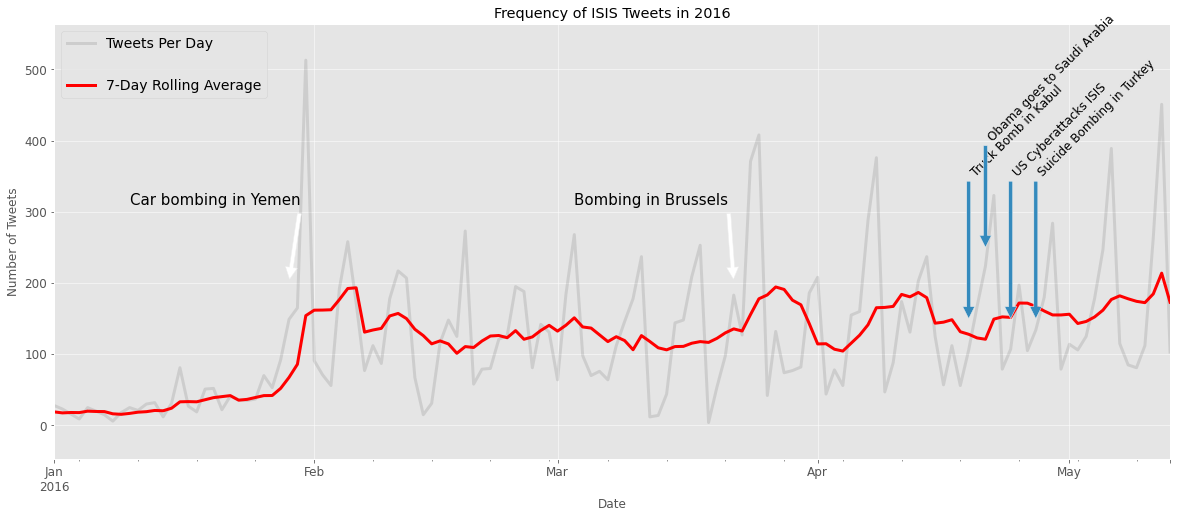

In [189]:
fig, ax = plt.subplots(figsize = (20,8))

perhr['2016-01-01':].numberstatuses.interpolate(method='linear').plot(ax = ax, color="black", fontsize=12, alpha=0.1)
#pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot(color ='r')
perhr.rolling(7).mean().tweets['2016-01-01':].plot(color='r')
#sns.timeseries(perhr, ax=ax)

yemen = '2016-01-29'
brussels = '2016-03-22'


ax.annotate('Bombing in Brussels',xy=(brussels, 200),xytext=('2016-03-03', 310),
            arrowprops=dict(facecolor='white', shrink=0.05), size=15)

ax.annotate('Car bombing in Yemen',xy=(yemen, 200),xytext=('2016-01-10', 310),
            arrowprops=dict(facecolor='white', shrink=0.05),size=15)

ax.margins(None,0.1)
ax.legend(['Tweets Per Day','7-Day Rolling Average'], loc = 'upper left',
           numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Frequency of ISIS Tweets in 2016')

apr19 = 'Truck Bomb in Kabul'
ax.annotate(apr19, xytext=('2016-4-19', 350), rotation=45,
            arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-19', 150),size=12)

apr21 = 'Obama goes to Saudi Arabia'
ax.annotate(apr21, xytext=('2016-4-21', 400), rotation=45,
            arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-21',250),size=12)

apr24 = 'US Cyberattacks ISIS'
ax.annotate(apr24, xytext=('2016-4-24', 350), rotation=45,
            arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-24', 150),size=12)

apr27 = 'Suicide Bombing in Turkey'
ax.annotate(apr27, xytext=('2016-4-27', 350), rotation=45,
            arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-27', 150),size=12)

fig.savefig('temp.png')
plt.show()

In [175]:
import datetime

from matplotlib import style
plt.style.use('ggplot')

data = pd.read_csv(r"D:\Users\Keerthana\Downloads\data\tweets.csv", parse_dates=['time'], infer_datetime_format=True)

def tsimple(x):
    return datetime.datetime(x.year, x.month, x.day)

data['time'] = data.time.apply(tsimple)

#### TOP USERS

<AxesSubplot:title={'center':'Top 10 Twitter Handles'}>

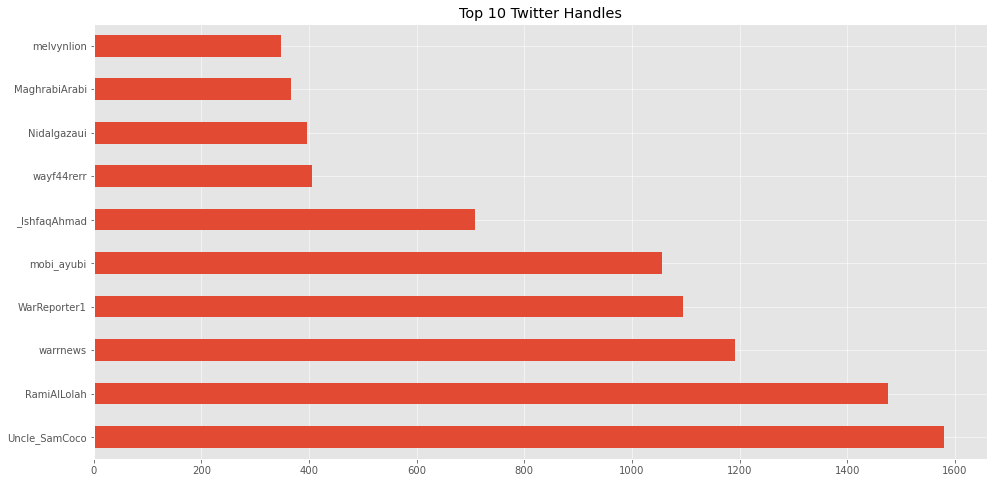

In [176]:
top_handles = data.username.value_counts().sort_values(ascending=False)
top_handles.head(10).plot.barh(title='Top 10 Twitter Handles',
                               figsize=(16,8))

<AxesSubplot:title={'center':'ISIS related tweets over time'}>

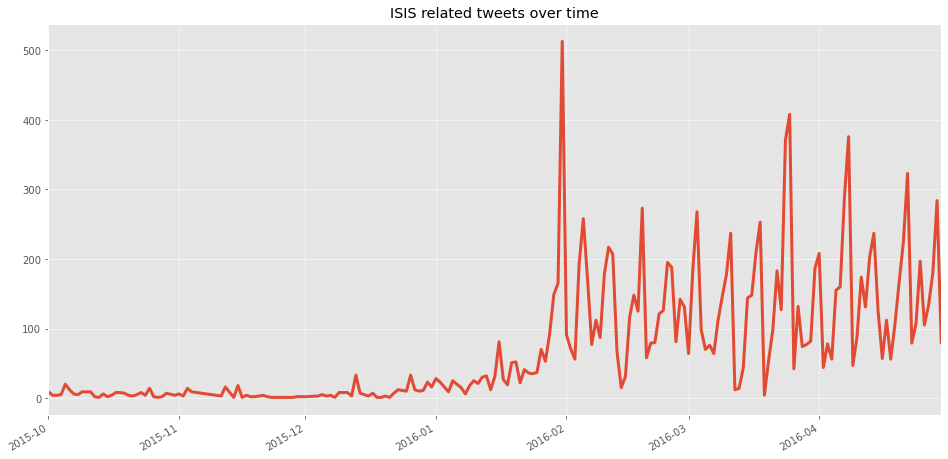

In [177]:
data.time.value_counts().plot(title='ISIS related tweets over time',
                              xlim=[datetime.date(2015, 10, 1),datetime.date(2016, 4, 30)],
                              figsize=(16,8))

<AxesSubplot:title={'center':'Total number of ISIS related tweets over time'}>

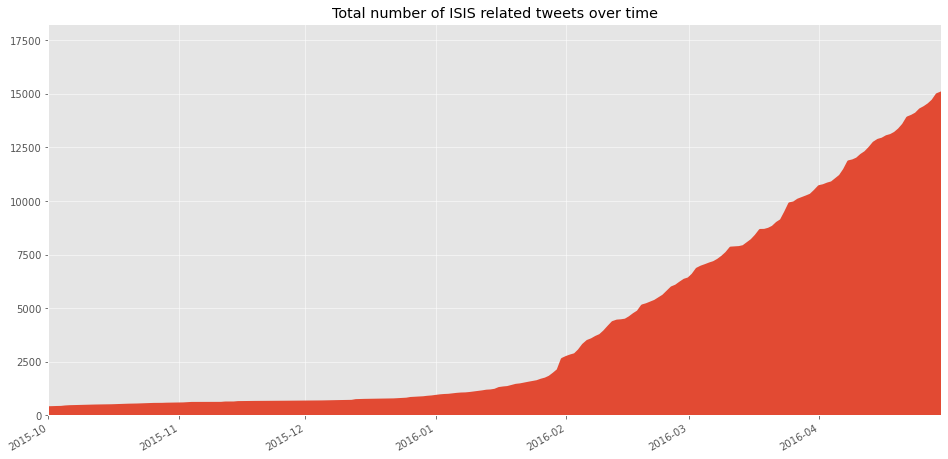

In [178]:
data.time.value_counts().sort_index().cumsum().plot.area(title='Total number of ISIS related tweets over time',
                                                         xlim=[datetime.date(2015, 10, 1),datetime.date(2016, 4, 30)],
                                                         figsize=(16,8))